In [71]:
import numpy as np
from scipy.integrate import solve_bvp
from scipy.integrate._bvp import BVPResult
from matplotlib import pyplot as plt

from typing import List, Tuple, Callable, Optional

from matplotlib import animation

from scipy.special import ellipe
from operator import itemgetter

In [78]:
YEAR_TO_SEC = 31536000
class Planet:
    """Model an orbitting & offset planet."""
    
    
    def __init__(
        self,
        name: str,
        mass: float,
        R: Optional[Tuple[float, float]],
        velocity: float,
        radius: float = 0,
        t0_years: float = 0,
        offset: Optional[Tuple[float, float]] = None
    ):
        """Create a planet.

        Args:
            name (str): The name.
            mass (float): Mass in KG.
            R (Optional[Tuple[float, float]]): Major and minor radii lengths in KM, or None for no orbitting.
            velocity (float): Speed in m/s of orbit.
            radius (float, optional): Planetary radius in meters. Defaults to 0.
            t0_years (float, optional): initial time offset along orbit, IN YEARS. Defaults to 0.
            offset (Optional[Tuple[float, float]], optional): X and Y offset 
                to orbit center, or None for centered at origin. Defaults to None.
        """
            
        #Initialize parameters
        self.mass = mass
        self.t0_years = t0_years
        self.R = R
        if R is not None:
            self.R1 = R[0]
            self.R2 = R[1]
        self.velocity = velocity
        self.name = name
        self.radius = radius
        
        
        if self.R is not None:

            # calculate the circumference of the ellipse using scipy special ellipse integral
            eccentricity_squared = 1-(self.R2**2)/(self.R1**2)
            Circumference = 4*self.R1*ellipe(eccentricity_squared)
            
            #calculate angular velocity given circumference of orbit, velocity:
            # (m/s)/m = /s, /s *2*pi = radians/s = ω, angular frequency/velocity
            # So we need 2π*velocity/circumference
            self.omega = 2*np.pi*velocity/Circumference #omega is in units of radians/second
            
        self.offset = offset
    
    def px(self,t_sec: np.ndarray) -> np.ndarray:
        """Get the planet's x position over time.

        Args:
            t_sec (np.ndarray): time values, in seconds.

        Returns:
            np.ndarray: x position values, in meters.
        """
        t_new = t_sec + self.t0_years*YEAR_TO_SEC 
        return (
            (np.ones_like(t_new)*self.offset[0] if self.offset is not None else np.zeros_like(t_new))
            + (self.R1*np.cos(self.omega*t_new) if self.R is not None else np.zeros_like(t_new))
        )
    
    def py(self,t_sec: np.ndarray) -> np.ndarray:
        """Get the planet's y position over time.

        Args:
            t_sec (np.ndarray): time values, in seconds.

        Returns:
            np.ndarray: y position values in meters.
        """

        t_new = t_sec + self.t0_years*YEAR_TO_SEC
        return (
            (np.ones_like(t_new)*self.offset[1] if self.offset is not None else np.zeros_like(t_new))
            + (self.R2*np.sin(self.omega*t_new) if self.R is not None else np.zeros_like(t_new))
        )
    
    def velocity_vector(self, t_sec: np.ndarray) -> np.ndarray:
        """Get the tangential velocity vector of the planet at a given time.

        Args:
            t_sec (np.ndarray): the times.

        Returns:
            np.ndarray: The X and Y tangential speeds in m/s.
        """

        t_new = t_sec + self.t0_years*YEAR_TO_SEC
        if self.R is not None:
            return self.omega*np.array([-self.R1*np.sin(self.omega*t_new),self.R2*np.cos(self.omega*t_new)])
        else:
            return np.array([np.zeros_like(t_new), np.zeros_like(t_new)])

In [4]:
YEAR_TO_SEC = 31536000

def best_path(
    planets: List[Planet],
    T: float,
    figname: str, #| None = None,
    animname: str, # | None = None,
    N_COMPUTE_STEPS: int = 10000,
    N_ANIM_FRAMES: int = 50,
    ANIM_LEN_SEC: float = 3,
    max_nodes: int = 100000,
    G: float = -6.674e-11,
) -> BVPResult:
    """Solve a boundary value problem to get from planet 0 to planet 1. Graph and animate results.

    Args:
        planets (List[PlanetType]): List of planets. Must have at least 2.
        T (float): Final time.
        figname (str | None, optional): If str, save a figure to this path. Defaults to None.
        animname (str | None, optional): If str, save an animation to this path. Defaults to None.
        N_COMPUTE_STEPS (int, optional): Number of time steps to use. Defaults to 10000.
        N_ANIM_FRAMES (int, optional): Number of frames in the animation total. Defaults to 50.
        ANIM_LEN_SEC (float, optional): Duration of the animation. Defaults to 3.
        max_nodes (int, optional): Max nodes for BVP solver. 1000 ends too quickly.
        G (float, optional): Gravitational constant. Defaults to 6.674e-11.
    Returns:
        BVPResult: Result of solving the BVP.
    """

    # this stores a list of planets with each planet's mass and position with [mass, pos_x, pos_y]

    def norm(sx, sy, px, py):
        return ((sx-px)**2 + (sy-py)**2)**(1/2)
    

    M = 0.
    
    def ode(t, y):
        '''
        sx: spaceship x position
        sy: spaceship y position
        dsx: spaceship x velocity
        dsy: spaceship y velocity
        fuel: fuel at time t
        p1, p2, p3, p4: costate vars
            '''
        
        sx, sy = y[0], y[1]
        dsx, dsy = y[2], y[3]
        p1, p2, p3, p4 = y[4], y[5], y[6], y[7]

        # ddsx = G * sum([mp*(sx-px(t))/(norm(sx, sy, px(t), py(t)))**3 for mp, px, py in planets] + p3/2)
        # ddsy = G * sum([mp*(sy-py(t))/(norm(sx, sy, px(t), py(t)))**3 for mp, px, py in planets] + p4/2)

        # dp1 = -p3*(G * sum([mp/norm(sx, sy, px(t), py(t))**3 - 3*mp*(sx - px(t))**2/norm(sx, sy, px(t), py(t))**5 for mp, px, py in planets]))
        # dp2 = -p4*(G * sum([mp/norm(sx, sy, px(t), py(t))**3 - 3*mp*(sy - py(t))**2/norm(sx, sy, px(t), py(t))**5 for mp, px, py in planets]))
        
        ddsx = 0
        ddsy = 0
        dp1 = 0
        dp2 = 0
        
        for planet in planets:
            dist = norm(sx, sy, planet.px(t), planet.py(t))
            dist3 = dist**3
            dist5 = dist**5
            dx = sx - planet.px(t)
            dy = sy - planet.py(t)
            
            ddsx += planet.mass*dx/dist3
            ddsy += planet.mass*dy/dist3

            dp1 += planet.mass/dist3 - 3*planet.mass*dx**2/dist5
            dp2 += planet.mass/dist3 - 3*planet.mass*dy**2/dist5

        ddsx = G * ddsx + p3/2
        ddsy = G * ddsx + p4/2
        
        dp1 = -p3*G*dp1
        dp2 = -p4*G*dp2
        
        dp3 = -p1 + M*dsx
        dp4 = -p2 + M*dsy

        return np.array([dsx, dsy, ddsx, ddsy, dp1, dp2, dp3, dp4])

    #Position BCs
    #add in the radius of the planet
    target_start_x = planets[0].px(0) + planets[0].radius
    target_start_y = planets[0].py(0)
    target_end_x = planets[1].px(T*YEAR_TO_SEC)+ planets[1].radius
    target_end_y = planets[1].py(T*YEAR_TO_SEC)
    #Velocity BCs
    velocity_start_x,velocity_start_y = planets[0].velocity_vector(0)
    velocity_end_x,velocity_end_y = planets[1].velocity_vector(T*YEAR_TO_SEC)
    # print(velocity_start_x,velocity_start_y,velocity_end_x,velocity_end_y,)
    
    # target_start_x = planets[0].px(0)
    # target_start_y = planet.
    # target_end_x = planets[1][1](T)
    # target_end_y = planets[1][2](T)
    def bc(ya, yb):
        return np.array([
            # Start at first planet x, y, with velocity matching the initial planet
            ya[0] - target_start_x,
            ya[1] - target_start_y,
            ya[2] - velocity_start_x,
            ya[3] - velocity_start_y,
            
            # End at second planet's x/y, with velocity matching the final planet
            yb[0] - target_end_x,
            yb[1] - target_end_y,
            yb[2] - velocity_end_x,
            yb[3] - velocity_end_y,
        ])

    t = np.linspace(0, T*YEAR_TO_SEC, N_COMPUTE_STEPS)
    y_guess = np.zeros((8, t.size))
    y_guess[0:2,0] = [target_start_x, target_start_y]
    y_guess[0:2,-1] = [target_end_x, target_end_y]

    print("Running solve_bvp...")
    soln = solve_bvp(ode, bc, t, y_guess, verbose=2, max_nodes=max_nodes)

    sx = soln.sol(t)[0]
    sy = soln.sol(t)[1]
    vx = soln.sol(t)[2]
    vy = soln.sol(t)[3]
    speed = np.sqrt(vx**2+vy**2)
    
    ux = soln.sol(t)[6]/2
    uy = soln.sol(t)[7]/2

    fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={"height_ratios": [2, 1]})
    
    #????????????????????????????????????????????????????????????????????????????????????
    masses = [planet.mass for planet in planets]
    min_mass = min(masses)
    max_mass = max(masses)
    min_radius = 5
    max_radius = 12
    def mass_to_radius(mass):
        return min_radius + (mass - min_mass) / (max_mass - min_mass+0.1) * (max_radius - min_radius)
    #????????????????????????????????????????????????????????????????????????????????????
    planet_x_ts = []
    planet_y_ts = []
    planet_trajectories = []
    planet_points = []

    #WE COULD USE THE PLANET CLASS PRE-BUILT PLOTTING TO DO THIS PROBABLY
    for i, planet in enumerate(planets):
        pxt = planet.px(t)
        pyt = planet.py(t)
        planet_x_ts.append(pxt)
        planet_y_ts.append(pyt)
        color = next(ax1._get_lines.prop_cycler)['color']
        planet_trajectories.append(ax1.plot(pxt, pyt, label=f'{planet.name}', color=color)[0])
        
        
        
        planet_points.append(ax1.plot(pxt[-1], pyt[-1], "o", color=color, markersize=mass_to_radius(planet.mass))[0])
    
    control_x_graph, = ax2.plot(t, ux, label='control in x direction')
    control_y_graph, = ax2.plot(t, uy, label='control in y direction')

    color = next(ax1._get_lines.prop_cycler)['color']

    ss_point, = ax1.plot(sx[-1], sy[-1], "o", color=color)
    ss_trajectory_plot, = ax1.plot(sx, sy, color=color, label='Optimal Path')
    
    ax1.set(xlabel="x", ylabel="y", title="Optimal Path")
    ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5, 0.3, 0.3), bbox_transform=ax1.transAxes)
    ax2.set(title='Optimal Control', xlabel="Time", ylabel="Acceleration")
    ax2.legend(loc="center left", bbox_to_anchor=(1, 0.5, 0.3, 0.3), bbox_transform=ax2.transAxes)
    fig.tight_layout()
    fig.show()
    # Save Figure if applicable
    if figname:
        fig.savefig(figname, dpi=300)
        print(f"Figure saved to {figname}")
    def plot_velocity():
        plt.figure()
        plt.plot(t,speed)
        plt.show()
    plot_velocity()
    # Animation
    def update_anim(anim_frame):
        
        i = min(N_COMPUTE_STEPS-1, int((anim_frame+1) / N_ANIM_FRAMES * N_COMPUTE_STEPS))
        
        # update spaceship graph
        ss_trajectory_plot.set_xdata(sx[:i+1])
        ss_trajectory_plot.set_ydata(sy[:i+1])
        # update spaceship dot
        ss_point.set_xdata(sx[i])
        ss_point.set_ydata(sy[i])
        
        # update planets
        for j, _ in enumerate(planets):
            planet_trajectories[j].set_xdata(planet_x_ts[j][:i+1])
            planet_trajectories[j].set_ydata(planet_y_ts[j][:i+1])
            
            planet_points[j].set_xdata(planet_x_ts[j][i])
            planet_points[j].set_ydata(planet_y_ts[j][i])
        
        # update control expenditure
        control_x_graph.set_xdata(t[:i+1])
        control_x_graph.set_ydata(ux[:i+1])
        
        control_y_graph.set_xdata(t[:i+1])
        control_y_graph.set_ydata(uy[:i+1])
        
    # Run and Save Animation if applicable
    if animname: 
        print("Saving animation...")   
        anim = animation.FuncAnimation(fig, update_anim, range(N_ANIM_FRAMES), interval=ANIM_LEN_SEC * 1000 // N_ANIM_FRAMES)
        anim.save(animname,dpi=300)
        print(f"Animation saved to {animname}")

    plt.close()
    
    

Running solve_bvp...
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.32e+03       1.89e+03         10000            4       
       2          5.87e+02       1.18e+02         10004           12       
       3          5.63e+02       6.37e+01         10016           228      
       4          3.67e+00       1.05e-10         10244           89       
       5          5.31e+00       4.05e-11         10333           228      
       6          3.56e+01       3.05e-05         10561           597      
       7          8.40e+00       3.05e-05         11158          1431      
       8          3.73e+01       6.10e-05         12589          3489      
       9          4.45e+01       6.10e-05         16078          8745      
      10          1.58e+02       3.05e-05         24823         (22631)    
Number of nodes is exceeded after iteration 10. 
Maximum relative residual: 1.58e+02 
Maximum boundary residual: 3.05e-05


/var/folders/t7/fm4bzyds14x6dsdw4f5c82dm0000gn/T/ipykernel_41115/2785033255.py:176: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Figure saved to Earth_Mars_test_newG_M_4.png


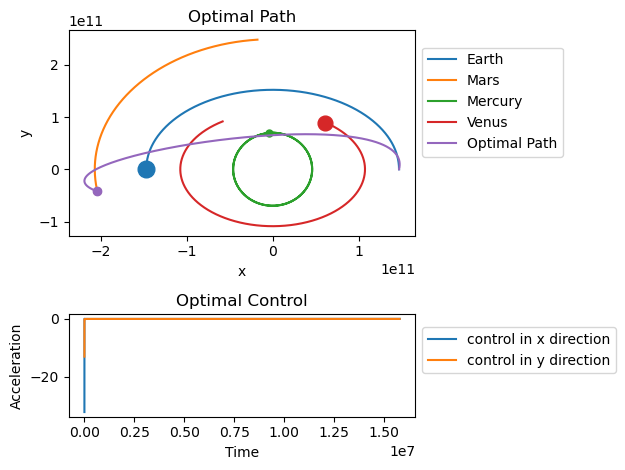

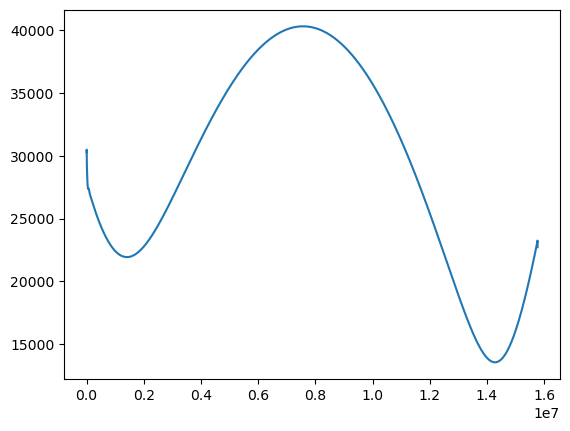

Saving animation...


/var/folders/t7/fm4bzyds14x6dsdw4f5c82dm0000gn/T/ipykernel_41115/2785033255.py:195: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ss_point.set_xdata(sx[i])
/var/folders/t7/fm4bzyds14x6dsdw4f5c82dm0000gn/T/ipykernel_41115/2785033255.py:196: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ss_point.set_ydata(sy[i])
/var/folders/t7/fm4bzyds14x6dsdw4f5c82dm0000gn/T/ipykernel_41115/2785033255.py:203: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  planet_points[j].set_xdata(planet_x_ts[j][i])
/var/folders/t7/fm4bzyds14x6dsdw4f5c82dm0000gn/T/ipykernel_41115/2785033255.py:204: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  planet_points[

Animation saved to Earth_Mars_test_newG_M_4.mp4


In [5]:
#Test it with the planets class:
best_path(
    inner_planets:= [
        Planet(name='Earth',mass=5.9722e24,R1=147.1e9,R2=152.1e9,velocity = 29.78e3,t0=0,radius=6378e3),
        Planet(name='Mars',mass=6.39e23,R1=207e9,R2=249e9,velocity = 24e3,t0=.5,radius=3390e3),
        Planet(name='Mercury',mass=3.285e23,R1=46e9,R2=69.82e9,velocity = 47.36e3,t0=.55,radius=2440e3),
        Planet(name='Venus',mass=4.8675e24,R1=107.48e9,R2=108.94e9,velocity = 35.02e3,t0=0.21,radius=6051e3),
    ],
    0.5, 
    figname='Earth_Mars_test_newG_M_4.png',
    animname="Earth_Mars_test_newG_M_4.mp4",
    max_nodes=30000,
    G=-6.674e-11,
)

In [6]:


def best_path_tf(
    planets: List[Planet],
    p0: float,
    y_guess: np.ndarray,
    figname: str, # | None = None,
    animname: str, # | None = None,
    N_COMPUTE_STEPS: int = 10000,
    N_ANIM_FRAMES: int = 50,
    ANIM_LEN_SEC: float = 3,
    max_nodes: int = 100000,
    G: float = -6.674e-11,
) -> BVPResult:
    """Solve a boundary value problem to get from planet 0 to planet 1. Graph and animate results.

    Args:
        planets (List[PlanetType]): List of planets. Must have at least 2.
        T (float): Final time.
        figname (str | None, optional): If str, save a figure to this path. Defaults to None.
        animname (str | None, optional): If str, save an animation to this path. Defaults to None.
        N_COMPUTE_STEPS (int, optional): Number of time steps to use. Defaults to 10000.
        N_ANIM_FRAMES (int, optional): Number of frames in the animation total. Defaults to 50.
        ANIM_LEN_SEC (float, optional): Duration of the animation. Defaults to 3.
        max_nodes (int, optional): Max nodes for BVP solver. 1000 ends too quickly.
        G (float, optional): Gravitational constant. Defaults to 6.674e-11.
    Returns:
        BVPResult: Result of solving the BVP.
    """

    # this stores a list of planets with each planet's mass and position with [mass, pos_x, pos_y]

    def norm(sx, sy, px, py):
        return ((sx-px)**2 + (sy-py)**2)**(1/2)
    

    M = 0
    
    def ode(t, y, p):
        '''
        sx: spaceship x position
        sy: spaceship y position
        dsx: spaceship x velocity
        dsy: spaceship y velocity
        fuel: fuel at time t
        p1, p2, p3, p4: costate vars
            '''
        tf = p[0]
        sx, sy = y[0], y[1]
        dsx, dsy = y[2], y[3]
        p1, p2, p3, p4 = y[4], y[5], y[6], y[7]

        # ddsx = G * sum([mp*(sx-px(t))/(norm(sx, sy, px(t), py(t)))**3 for mp, px, py in planets] + p3/2)
        # ddsy = G * sum([mp*(sy-py(t))/(norm(sx, sy, px(t), py(t)))**3 for mp, px, py in planets] + p4/2)

        # dp1 = -p3*(G * sum([mp/norm(sx, sy, px(t), py(t))**3 - 3*mp*(sx - px(t))**2/norm(sx, sy, px(t), py(t))**5 for mp, px, py in planets]))
        # dp2 = -p4*(G * sum([mp/norm(sx, sy, px(t), py(t))**3 - 3*mp*(sy - py(t))**2/norm(sx, sy, px(t), py(t))**5 for mp, px, py in planets]))
        
        ddsx = 0
        ddsy = 0
        dp1 = 0
        dp2 = 0
        
        for planet in planets:
            dist = norm(sx, sy, planet.px(t*tf), planet.py(t*tf))
            dist3 = dist**3
            dist5 = dist**5
            dx = sx - planet.px(t*tf)
            dy = sy - planet.py(t*tf)
            
            ddsx += planet.mass*dx/dist3
            ddsy += planet.mass*dy/dist3

            dp1 += planet.mass/dist3 - 3*planet.mass*dx**2/dist5
            dp2 += planet.mass/dist3 - 3*planet.mass*dy**2/dist5

        ddsx = G * ddsx + p3/2
        ddsy = G * ddsx + p4/2
        
        dp1 = -p3*G*dp1
        dp2 = -p4*G*dp2
        
        dp3 = -p1 + M*dsx
        dp4 = -p2 + M*dsy

        return tf*np.array([dsx, dsy, ddsx, ddsy, dp1, dp2, dp3, dp4])

    #Position BCs
    #add in the radius of the planet
    target_start_x = planets[0].px(0) + planets[0].radius
    target_start_y = planets[0].py(0)
    # target_end_x = planets[1].px(0)+ planets[1].radius
    # target_end_y = planets[1].py(T*YEAR_TO_SEC)
    #Velocity BCs
    velocity_start_x,velocity_start_y = planets[0].velocity_vector(0)
    # velocity_end_x,velocity_end_y = planets[1].velocity_vector(1)
    # print(velocity_start_x,velocity_start_y,velocity_end_x,velocity_end_y,)
    
    # target_start_x = planets[0].px(0)
    # target_start_y = planet.
    # target_end_x = planets[1][1](T)
    # target_end_y = planets[1][2](T)
    def bc(ya, yb, p):
        tf = p[0]
        sx, sy = yb[0], yb[1]
        dsx, dsy = yb[2], yb[3]
        p1, p2, p3, p4 = yb[4], yb[5], yb[6], yb[7]
        ddsx = 0
        ddsy = 0
        for planet in planets:
            dist = norm(sx, sy, planet.px(tf), planet.py(tf))
            dist3 = dist**3
            dx = sx - planet.px(tf)
            dy = sy - planet.py(tf)
            
            ddsx += planet.mass*dx/dist3
            ddsy += planet.mass*dy/dist3

        h = p1*dsx + p2*dsy + p3*(G*ddsx + p3/2) + p4*(G*ddsy+p4/2) - (p3/2)**2 - (p4/2)**2

        target_end_y = planets[1].py(tf)
        target_end_x = planets[1].px(tf)+ planets[1].radius
        velocity_end_x, velocity_end_y = planets[1].velocity_vector(tf)
        
        return np.array([
            # Start at first planet x, y, with velocity matching the initial planet
            ya[0] - target_start_x,
            ya[1] - target_start_y,
            ya[2] - velocity_start_x,
            ya[3] - velocity_start_y,

            # End at second planet's x/y, with velocity matching the final planet
            yb[0] - target_end_x,
            yb[1] - target_end_y,
            yb[2] - velocity_end_x,
            yb[3] - velocity_end_y,
            h
        ])

    t = np.linspace(0, 1, N_COMPUTE_STEPS)
    # y_guess[0:2,0] = [target_start_x, target_start_y]
    # y_guess[0:2,-1] = [target_end_x, target_end_y]

    print("Running solve_bvp...")
    soln = solve_bvp(ode, bc, t, y_guess, p=np.array([p0*YEAR_TO_SEC]), verbose=2, max_nodes=max_nodes)
    tf = soln.p[0]
     
    sx = soln.sol(t)[0]
    sy = soln.sol(t)[1]
    vx = soln.sol(t)[2]
    vy = soln.sol(t)[3]
    speed = np.sqrt(vx**2+vy**2)
    
    ux = soln.sol(t)[6]/2
    uy = soln.sol(t)[7]/2

    fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={"height_ratios": [2, 1]})
    
    #????????????????????????????????????????????????????????????????????????????????????
    masses = [planet.mass for planet in planets]
    min_mass = min(masses)
    max_mass = max(masses)
    min_radius = 5
    max_radius = 12
    def mass_to_radius(mass):
        return min_radius + (mass - min_mass) / (max_mass - min_mass+0.1) * (max_radius - min_radius)
    #????????????????????????????????????????????????????????????????????????????????????
    planet_x_ts = []
    planet_y_ts = []
    planet_trajectories = []
    planet_points = []

    #WE COULD USE THE PLANET CLASS PRE-BUILT PLOTTING TO DO THIS PROBABLY
    for i, planet in enumerate(planets):
        pxt = planet.px(t*tf)
        pyt = planet.py(t*tf)
        planet_x_ts.append(pxt)
        planet_y_ts.append(pyt)
        color = next(ax1._get_lines.prop_cycler)['color']
        planet_trajectories.append(ax1.plot(pxt, pyt, label=f'{planet.name}', color=color)[0])
        
        
        
        planet_points.append(ax1.plot(pxt[-1], pyt[-1], "o", color=color, markersize=mass_to_radius(planet.mass))[0])
    
    control_x_graph, = ax2.plot(t, ux, label='control in x direction')
    control_y_graph, = ax2.plot(t, uy, label='control in y direction')

    color = next(ax1._get_lines.prop_cycler)['color']

    ss_point, = ax1.plot(sx[-1], sy[-1], "o", color=color)
    ss_trajectory_plot, = ax1.plot(sx, sy, color=color, label='Optimal Path')
    
    ax1.set(xlabel="x", ylabel="y", title="Optimal Path")
    ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5, 0.3, 0.3), bbox_transform=ax1.transAxes)
    ax2.set(title='Optimal Control', xlabel="Time", ylabel="Acceleration")
    ax2.legend(loc="center left", bbox_to_anchor=(1, 0.5, 0.3, 0.3), bbox_transform=ax2.transAxes)
    fig.tight_layout()
    fig.show()
    # Save Figure if applicable
    if figname:
        fig.savefig(figname, dpi=300)
        print(f"Figure saved to {figname}")
    def plot_velocity():
        plt.figure()
        plt.plot(t,speed)
        plt.show()
    plot_velocity()
    # Animation
    def update_anim(anim_frame):
        
        i = min(N_COMPUTE_STEPS-1, int((anim_frame+1) / N_ANIM_FRAMES * N_COMPUTE_STEPS))
        
        # update spaceship graph
        ss_trajectory_plot.set_xdata(sx[:i+1])
        ss_trajectory_plot.set_ydata(sy[:i+1])
        # update spaceship dot
        ss_point.set_xdata(sx[i])
        ss_point.set_ydata(sy[i])
        
        # update planets
        for j, _ in enumerate(planets):
            planet_trajectories[j].set_xdata(planet_x_ts[j][:i+1])
            planet_trajectories[j].set_ydata(planet_y_ts[j][:i+1])
            
            planet_points[j].set_xdata(planet_x_ts[j][i])
            planet_points[j].set_ydata(planet_y_ts[j][i])
        
        # update control expenditure
        control_x_graph.set_xdata(t[:i+1])
        control_x_graph.set_ydata(ux[:i+1])
        
        control_y_graph.set_xdata(t[:i+1])
        control_y_graph.set_ydata(uy[:i+1])
        
    # Run and Save Animation if applicable
    if animname: 
        print("Saving animation...")   
        anim = animation.FuncAnimation(fig, update_anim, range(N_ANIM_FRAMES), interval=ANIM_LEN_SEC * 1000 // N_ANIM_FRAMES)
        anim.save(animname,dpi=300)
        print(f"Animation saved to {animname}")

    plt.close()

    return tf/YEAR_TO_SEC, t, soln
    
    

Running solve_bvp...
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          6.72e+01       3.95e+00         10000          19998     
       2          4.19e+02       5.11e+03         29998         (7933)     
Number of nodes is exceeded after iteration 2. 
Maximum relative residual: 4.19e+02 
Maximum boundary residual: 5.11e+03


/var/folders/t7/fm4bzyds14x6dsdw4f5c82dm0000gn/T/ipykernel_41115/1877102244.py:199: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Figure saved to Earth_Mars_tf.png


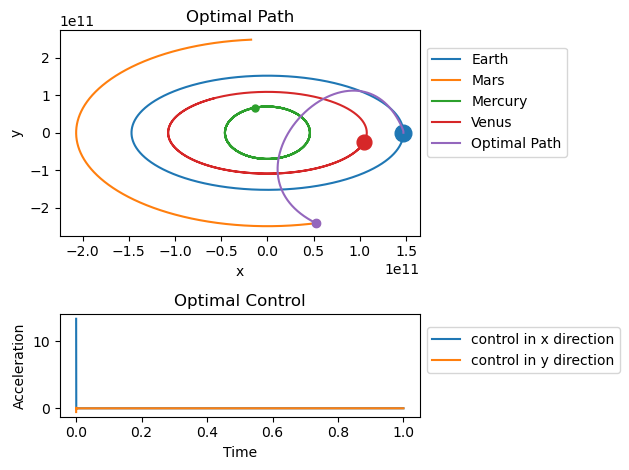

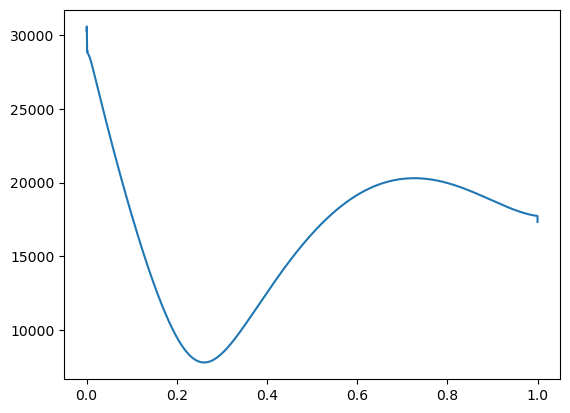

Saving animation...


/var/folders/t7/fm4bzyds14x6dsdw4f5c82dm0000gn/T/ipykernel_41115/1877102244.py:218: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ss_point.set_xdata(sx[i])
/var/folders/t7/fm4bzyds14x6dsdw4f5c82dm0000gn/T/ipykernel_41115/1877102244.py:219: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ss_point.set_ydata(sy[i])
/var/folders/t7/fm4bzyds14x6dsdw4f5c82dm0000gn/T/ipykernel_41115/1877102244.py:226: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  planet_points[j].set_xdata(planet_x_ts[j][i])
/var/folders/t7/fm4bzyds14x6dsdw4f5c82dm0000gn/T/ipykernel_41115/1877102244.py:227: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  planet_points[

Animation saved to Earth_Mars_tf.mp4


(0.9999997314505532,
 array([0.00000000e+00, 1.00010001e-04, 2.00020002e-04, ...,
        9.99799980e-01, 9.99899990e-01, 1.00000000e+00]),
        message: 'The maximum number of mesh nodes is exceeded.'
          niter: 2
              p: array([31535991.53102465])
  rms_residuals: array([3.77530516e+01, 4.18978251e+02, 2.32528207e-01, ...,
        2.01417005e+00, 1.70339265e+00, 5.03072973e+00])
            sol: <scipy.interpolate.interpolate.PPoly object at 0x7fe132d6d9f0>
         status: 1
        success: False
              x: array([0.00000000e+00, 3.33366670e-05, 6.66733340e-05, ...,
        9.99933327e-01, 9.99966663e-01, 1.00000000e+00])
              y: array([[ 1.47106378e+11,  1.47101581e+11,  1.47089294e+11, ...,
          5.24820038e+10,  5.24937723e+10,  5.25055443e+10],
        [ 0.00000000e+00,  3.15963083e+07,  6.30872409e+07, ...,
         -2.40828866e+11, -2.40843329e+11, -2.40857791e+11],
        [ 0.00000000e+00, -1.23127488e+04, -7.83630700e+03, ...,
         

In [14]:
#Test it with the planets class:
best_path_tf(
    inner_planets,
    1, 
    y_guess = np.ones((8, 10000))*10000,
    figname='Earth_Mars_tf.png',
    animname="Earth_Mars_tf.mp4",
    max_nodes=30000,
    N_COMPUTE_STEPS=10000,
    G=-6.674e-11,
)

In [121]:
YEAR_TO_SEC = 31536000

def best_path_t0(
    planets: List[Planet],
    t0_guess: float,
    y_guess: np.ndarray,
    T: float,
    figname: str,# | None = None,
    animname: str ,#| None = None,
    N_COMPUTE_STEPS: int = 10000,
    N_ANIM_FRAMES: int = 50,
    ANIM_LEN_SEC: float = 3,
    max_nodes: int = 100000,
    G: float = -6.674e-11,
) -> BVPResult:
    """Solve a boundary value problem to get from planet 0 to planet 1. Graph and animate results.

    Args:
        planets (List[PlanetType]): List of planets. Must have at least 2.
        T (float): Final time.
        figname (str | None, optional): If str, save a figure to this path. Defaults to None.
        animname (str | None, optional): If str, save an animation to this path. Defaults to None.
        N_COMPUTE_STEPS (int, optional): Number of time steps to use. Defaults to 10000.
        N_ANIM_FRAMES (int, optional): Number of frames in the animation total. Defaults to 50.
        ANIM_LEN_SEC (float, optional): Duration of the animation. Defaults to 3.
        max_nodes (int, optional): Max nodes for BVP solver. 1000 ends too quickly.
        G (float, optional): Gravitational constant. Defaults to 6.674e-11.
    Returns:
        BVPResult: Result of solving the BVP.
    """

    # this stores a list of planets with each planet's mass and position with [mass, pos_x, pos_y]
    
    tf = T * YEAR_TO_SEC
    
    def ode(t, y, p):
        '''
        sx: spaceship x position
        sy: spaceship y position
        dsx: spaceship x velocity
        dsy: spaceship y velocity
        fuel: fuel at time t
        p1, p2, p3, p4: costate vars
            '''
        t0 = p[0]
        t_hat = t0 + (tf-t0)*t
        sx, sy = y[0], y[1]
        dsx, dsy = y[2], y[3]
        p1, p2, p3, p4 = y[4], y[5], y[6], y[7]

        ddsx = 0
        ddsy = 0
        dp1 = 0
        dp2 = 0
        
        for planet in planets:
            px_t = planet.px(t_hat)
            py_t = planet.py(t_hat)
            dist = np.linalg.norm(np.array([sx-px_t, sy - py_t]))
            
            dist3 = np.exp(3*np.log(dist))
            dist5 = np.exp(5*np.log(dist))
            dx = sx - planet.px(t_hat)
            dy = sy - planet.py(t_hat)
            
            # Do these operations in log space for numerical stability.
            ddsx += dx*np.exp(np.log(planet.mass) - np.log(dist3))
            ddsy += dy*np.exp(np.log(planet.mass) - np.log(dist3))

            dp1 += np.exp(np.log(planet.mass) - np.log(dist3)) - 3*dx**2*np.exp(np.log(planet.mass) - np.log(dist5))
            dp2 += np.exp(np.log(planet.mass) - np.log(dist3)) - 3*dy**2*np.exp(np.log(planet.mass) - np.log(dist5))

        ddsx = -G * ddsx + p3/2
        ddsy = -G * ddsy + p4/2
        
        dp1 = p3*G*dp1
        dp2 = p4*G*dp2
        
        dp3 = -p1 
        dp4 = -p2 

        return (tf-t0)*np.array([dsx, dsy, ddsx, ddsy, dp1, dp2, dp3, dp4])

    #Position BCs
    #add in the radius of the planet
    # target_start_x = planets[0].px(0) + planets[0].radius
    # target_start_y = planets[0].py(0)
    target_end_x = planets[1].px(tf)+ planets[1].radius
    target_end_y = planets[1].py(tf)
    #Velocity BCs
    # velocity_start_x,velocity_start_y = planets[0].velocity_vector(0)
    velocity_end_x,velocity_end_y = planets[1].velocity_vector(1)
    # print(velocity_start_x,velocity_start_y,velocity_end_x,velocity_end_y,)
    
    # target_start_x = planets[0].px(0)
    # target_start_y = planet.
    # target_end_x = planets[1][1](T)
    # target_end_y = planets[1][2](T)
    def bc(ya, yb, p):
        t0 = p[0]
        sx, sy = ya[0], ya[1]
        dsx, dsy = ya[2], ya[3]
        p1, p2, p3, p4 = ya[4], ya[5], ya[6], ya[7]

        ddsx = 0
        ddsy = 0

        for planet in planets:
            dist = np.linalg.norm(np.array([sx - planet.px(t0), sy - planet.py(t0)]))
            dist3 = np.exp(3*np.log(dist))
            dx = sx - planet.px(t0)
            dy = sy - planet.py(t0)
            
            # Do these operations in log space for numerical stability.
            ddsx += dx*np.exp(np.log(planet.mass) - np.log(dist3))
            ddsy += dy*np.exp(np.log(planet.mass) - np.log(dist3))

        h = p1*dsx + p2*dsy + p3*(G*ddsx + p3/2) + p4*(G*ddsy+p4/2) - (p3/2)**2 - (p4/2)**2
 
        target_start_y = planets[0].py(t0)
        target_start_x = planets[0].px(t0) + planets[0].radius
        velocity_start_x, velocity_start_y = planets[0].velocity_vector(t0)
        
        return np.array([
            # Start at first planet x, y, with velocity matching the initial planet
            ya[0] - target_start_x,
            ya[1] - target_start_y,
            ya[2] - velocity_start_x,
            ya[3] - velocity_start_y,

            # End at second planet's x/y, with velocity matching the final planet
            yb[0] - target_end_x,
            yb[1] - target_end_y,
            yb[2] - velocity_end_x,
            yb[3] - velocity_end_y,
            h
        ])
    
    t = np.linspace(0, 1, N_COMPUTE_STEPS)
    # y_guess[0:2,0] = [target_start_x, target_start_y]
    # y_guess[0:2,-1] = [target_end_x, target_end_y]

    print("Running solve_bvp...")
    soln = solve_bvp(ode, bc, t, y_guess, p=np.array([t0_guess*YEAR_TO_SEC]), verbose=2, max_nodes=max_nodes)
    t0 = soln.p[0]
    # tf = soln.p[1]
     
    sx = soln.sol(t)[0]
    sy = soln.sol(t)[1]
    vx = soln.sol(t)[2]
    vy = soln.sol(t)[3]
    speed = np.sqrt(vx**2+vy**2)
    
    ux = soln.sol(t)[6]/2
    uy = soln.sol(t)[7]/2

    fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={"height_ratios": [2, 1]})
    
    #????????????????????????????????????????????????????????????????????????????????????
    masses = [planet.mass for planet in planets]
    min_mass = min(masses)
    max_mass = max(masses)
    min_radius = 5
    max_radius = 12
    def mass_to_radius(mass):
        return min_radius + (mass - min_mass) / (max_mass - min_mass+0.1) * (max_radius - min_radius)
    #????????????????????????????????????????????????????????????????????????????????????
    planet_x_ts = []
    planet_y_ts = []
    planet_trajectories = []
    planet_points = []
    
    tp = t0 + t*(tf - t0)
    
    #WE COULD USE THE PLANET CLASS PRE-BUILT PLOTTING TO DO THIS PROBABLY
    for i, planet in enumerate(planets):
        pxt = planet.px(tp)
        pyt = planet.py(tp)
        planet_x_ts.append(pxt)
        planet_y_ts.append(pyt)
        color = next(ax1._get_lines.prop_cycler)['color']
        planet_trajectories.append(ax1.plot(pxt, pyt, label=f'{planet.name}', color=color)[0])
        
        
        
        planet_points.append(ax1.plot(pxt[-1], pyt[-1], "o", color=color, markersize=mass_to_radius(planet.mass))[0])
    
    control_x_graph, = ax2.plot(tp, ux, label='control in x direction')
    control_y_graph, = ax2.plot(tp, uy, label='control in y direction')

    color = next(ax1._get_lines.prop_cycler)['color']

    ss_point, = ax1.plot(sx[-1], sy[-1], "o", color=color)
    ss_trajectory_plot, = ax1.plot(sx, sy, color=color, label='Optimal Path')
    
    ax1.set(xlabel="x", ylabel="y", title="Optimal Path")
    ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5, 0.3, 0.3), bbox_transform=ax1.transAxes)
    ax2.set(title='Optimal Control', xlabel="Time", ylabel="Acceleration")
    ax2.legend(loc="center left", bbox_to_anchor=(1, 0.5, 0.3, 0.3), bbox_transform=ax2.transAxes)
    fig.tight_layout()
    fig.show()
    # Save Figure if applicable
    if figname:
        fig.savefig(figname, dpi=300)
        print(f"Figure saved to {figname}")
    def plot_velocity():
        plt.figure()
        plt.plot(t,speed)
        plt.show()
    plot_velocity()
    # Animation
    def update_anim(anim_frame):
        
        i = min(N_COMPUTE_STEPS-1, int((anim_frame+1) / N_ANIM_FRAMES * N_COMPUTE_STEPS))
        
        # update spaceship graph
        ss_trajectory_plot.set_xdata(sx[:i+1])
        ss_trajectory_plot.set_ydata(sy[:i+1])
        # update spaceship dot
        ss_point.set_xdata(sx[i])
        ss_point.set_ydata(sy[i])
        
        # update planets
        for j, _ in enumerate(planets):
            planet_trajectories[j].set_xdata(planet_x_ts[j][:i+1])
            planet_trajectories[j].set_ydata(planet_y_ts[j][:i+1])
            
            planet_points[j].set_xdata(planet_x_ts[j][i])
            planet_points[j].set_ydata(planet_y_ts[j][i])
        
        # update control expenditure
        control_x_graph.set_xdata(t[:i+1])
        control_x_graph.set_ydata(ux[:i+1])
        
        control_y_graph.set_xdata(t[:i+1])
        control_y_graph.set_ydata(uy[:i+1])
        
    # Run and Save Animation if applicable
    if animname: 
        print("Saving animation...")   
        anim = animation.FuncAnimation(fig, update_anim, range(N_ANIM_FRAMES), interval=ANIM_LEN_SEC * 1000 // N_ANIM_FRAMES)
        anim.save(animname,dpi=300)
        print(f"Animation saved to {animname}")

    plt.close()

    return t0/YEAR_TO_SEC, t, soln
    
    

-112422770910.8094 3027.554666421531


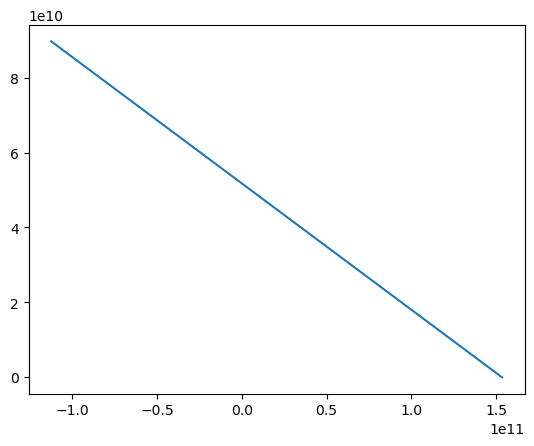

Running solve_bvp...
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.49e+02       2.37e+04         10000          19998     
       2          1.32e-04       9.38e+03         29998            0       
       3          1.51e-04       3.66e+04         29998            0       
       4          1.80e-05       1.09e+04         29998            0       
       5          7.58e-04       1.90e+04         29998            0       
       6          4.40e-04       1.95e+04         29998            0       
       7          8.37e-04       3.12e+04         29998            0       
       8          3.88e-03       1.66e+04         29998            1       
       9          7.14e-04       3.83e+04         29999            0       
      10          7.48e-05       4.07e+04         29999            0       
The solver was unable to satisfy boundary conditions tolerance on iteration 10. 
Maximum relative residual: 7.48e-05 
Maximum boundary residual

/var/folders/t7/fm4bzyds14x6dsdw4f5c82dm0000gn/T/ipykernel_41115/2404380328.py:201: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Figure saved to Earth_Mars_t0(1).png


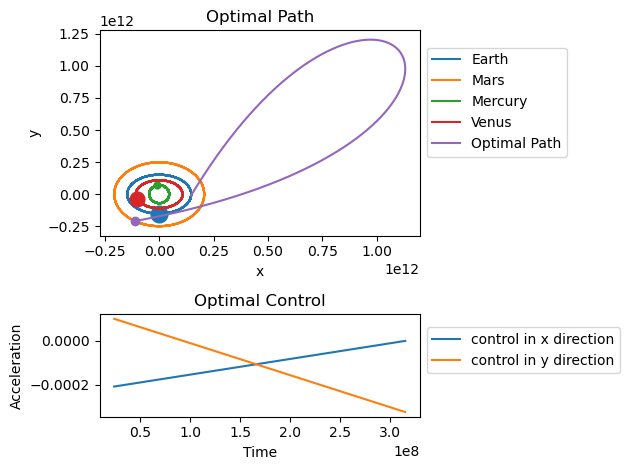

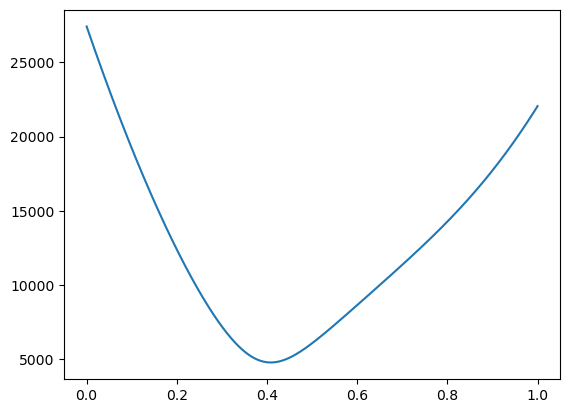

Saving animation...


/var/folders/t7/fm4bzyds14x6dsdw4f5c82dm0000gn/T/ipykernel_41115/2404380328.py:220: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ss_point.set_xdata(sx[i])
/var/folders/t7/fm4bzyds14x6dsdw4f5c82dm0000gn/T/ipykernel_41115/2404380328.py:221: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ss_point.set_ydata(sy[i])
/var/folders/t7/fm4bzyds14x6dsdw4f5c82dm0000gn/T/ipykernel_41115/2404380328.py:228: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  planet_points[j].set_xdata(planet_x_ts[j][i])
/var/folders/t7/fm4bzyds14x6dsdw4f5c82dm0000gn/T/ipykernel_41115/2404380328.py:229: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  planet_points[

Animation saved to Earth_Mars_t0(1).mp4


(10.000001807955242,
 array([0.00000000e+00, 1.00010001e-04, 2.00020002e-04, ...,
        9.99799980e-01, 9.99899990e-01, 1.00000000e+00]),
        message: 'The solver was unable to satisfy boundary conditions tolerance on iteration 10.'
          niter: 10
              p: array([3.15360057e+08])
  rms_residuals: array([1.71506115e-08, 1.48712473e-08, 1.40926576e-08, ...,
        1.58523455e-08, 1.58527237e-08, 1.58523728e-08])
            sol: <scipy.interpolate.interpolate.PPoly object at 0x7fdf88a73bd0>
         status: 3
        success: False
              x: array([0.00000000e+00, 3.33366670e-05, 6.66733340e-05, ...,
        9.99933327e-01, 9.99966663e-01, 1.00000000e+00])
              y: array([[ 1.46847403e+11,  1.46936730e+11,  1.47026057e+11, ...,
         -1.11587825e+11, -1.11792326e+11, -1.11996846e+11],
        [-9.02143209e+09, -8.77011726e+09, -8.51883298e+09, ...,
         -2.09275341e+11, -2.09339867e+11, -2.09404382e+11],
        [-9.18566744e+03, -9.18566734e+03,

In [128]:
#Test it with the planets class:
t0_guess = 10
T = 0.75
steps = 10000
y_guess = np.ones((8,10000))*-1050
y_guess[0] = np.linspace(inner_planets[0].px(.1) + inner_planets[0].radius*1000, inner_planets[0].px(0.4*YEAR_TO_SEC) + inner_planets[0].radius*1000, steps)
y_guess[1] = np.linspace(inner_planets[0].py(.1), inner_planets[0].py(0.4*YEAR_TO_SEC), steps)
print(np.min(y_guess[0]), np.min(y_guess[1]))
# vec = np.array([inner_planets[0].px(0.2*YEAR_TO_SEC) - inner_planets[0].px(0), inner_planets[0].py(0.2*YEAR_TO_SEC) - inner_planets[0].py(0)])
# vec = vec / np.linalg.norm(vec) #make it a unit vector that points from initial guess position to final guess position
# y_guess[2,:] = vec[0] * 50000
# y_guess[3,:] = vec[1] * 50000

y_guess[2:] = 1

plt.plot(y_guess[0], y_guess[1])
plt.show()

best_path_t0(
    inner_planets,
    t0_guess=t0_guess, 
    y_guess = y_guess,
    T=T,
    figname='Earth_Mars_t0(1).png',
    animname="Earth_Mars_t0(1).mp4",
    max_nodes=30000,
    N_COMPUTE_STEPS=steps,
    G=6.674e-11,
)